# 계정 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 전처리 (spaCy)

In [2]:
!pip install spacy

In [3]:
!pwd

/content


In [4]:
%cd ./drive/MyDrive/기계학습특론/5주차

/content/drive/MyDrive/기계학습특론/5주차


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import os
import json
import sklearn

from sklearn.model_selection import train_test_split

In [6]:
data_df = pd.read_csv("./application_data.csv")

In [9]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5417 entries, 0 to 5416
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   contents  5416 non-null   object
 1   star      5417 non-null   int64 
 2   agree     5417 non-null   int64 
 3   date      5417 non-null   object
dtypes: int64(2), object(2)
memory usage: 169.4+ KB


In [10]:
data_df = pd.read_csv("./application_data.csv")
data_df.head(3)

,contents,star,agree,date
0,"The app has a lot of content, from meals to me...",2,12,2023-08-26 13:34:07
1,"I have a subscription, but as I navigate throu...",1,21,2023-08-21 18:58:42
2,The program and workouts are great. The main i...,1,45,2023-08-25 11:54:49


<Axes: xlabel='star', ylabel='count'>

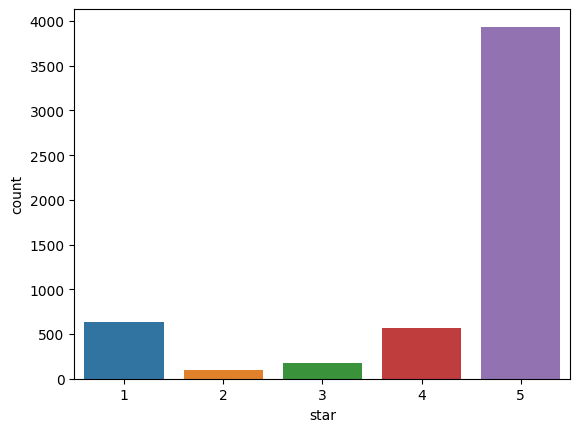

In [11]:
sns.countplot(x='star', data=data_df)

# 별점을 통해서 레이블링 작업을 수행

 (4, 5점은 긍정 // 1, 2점은 부정 // 3점은 중립으로 제외)

In [12]:
# 중립 제거
df_except_neut = data_df['star'] != 3
data_df = data_df[df_except_neut]

# 레이블링 할당 (긍정 : 1, 부정 : 0)
data_df['sentiment'] = [1 if i > 3 else 0 for i in data_df['star']]

# nan 값 제거
data_df = data_df.dropna()

# 중복 제거
data_df = data_df.drop_duplicates()

data_df.reset_index(drop=True, inplace=True)

data_df

<ipython-input-12-9d441f06bbc4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['sentiment'] = [1 if i > 3 else 0 for i in data_df['star']]


,contents,star,agree,date,sentiment
0,"The app has a lot of content, from meals to me...",2,12,2023-08-26 13:34:07,0
1,"I have a subscription, but as I navigate throu...",1,21,2023-08-21 18:58:42,0
2,The program and workouts are great. The main i...,1,45,2023-08-25 11:54:49,0
3,Doesn't work half the time. You can't open mos...,1,48,2023-08-21 15:18:24,0
4,Could use some more personalized features. Wou...,4,19,2023-07-24 12:50:26,1
...,...,...,...,...,...
5236,Chrisssss!,5,0,2023-04-03 06:09:27,1
5237,✖️,1,0,2023-01-07 11:57:17,0
5238,❤❤❤❤😍😍😍😍😍,5,0,2023-04-12 23:01:10,1
5239,Ok,5,0,2022-12-29 03:47:29,1


# 클래스의 차이 확인

(긍정 레이블과 부정 레이블의 차이를 확인하자!)

긍정 개수: 4500
부정 개수: 741


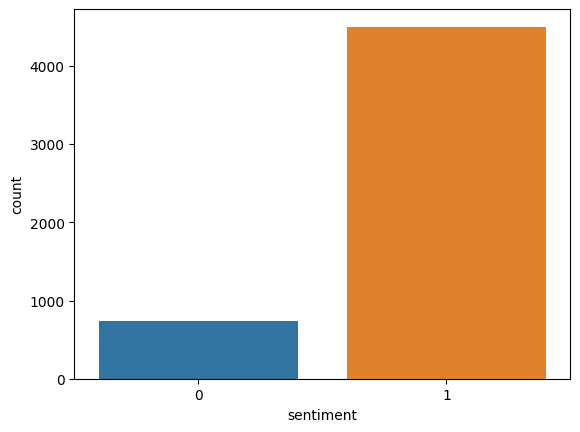

In [13]:
import seaborn as sns

sns.countplot(x='sentiment', data=data_df)
print("긍정 개수:", (data_df["sentiment"] == 1).sum())
print("부정 개수:", (data_df["sentiment"] == 0).sum())

In [14]:
def equal_ratio(df): #downsampling
    # 레이블링 확인
    pos = df['sentiment'] == 1
    neg = df['sentiment'] == 0

    # pos와 neg 구분
    pos = df[pos]
    neg = df[neg]

    # 이전 개수 출력
    print(len(pos),"before pos")
    print(len(neg),"before neg")

    # 비율 맞춤
    pos_len = len(pos)
    neg_len = len(neg)
    max_len = max(pos_len, neg_len)

    DFF = abs(pos_len - neg_len)
    ratio = 1 - (DFF / max_len)

    if pos_len == neg_len:
      pass
    elif pos_len > neg_len:
        pos = pos.sample(frac=ratio, random_state=82)
    else:
        neg = neg.sample(frac=ratio, random_state=82)

    # 이후 개수 출력
    print(len(pos),"after pos")
    print(len(neg),"after neg")

    df = pd.concat([pos, neg], axis=0)
    df = sklearn.utils.shuffle(df, random_state=82).reset_index(drop=True)

    return df

4500 before pos
741 before neg
741 after pos
741 after neg


<Axes: xlabel='sentiment', ylabel='count'>

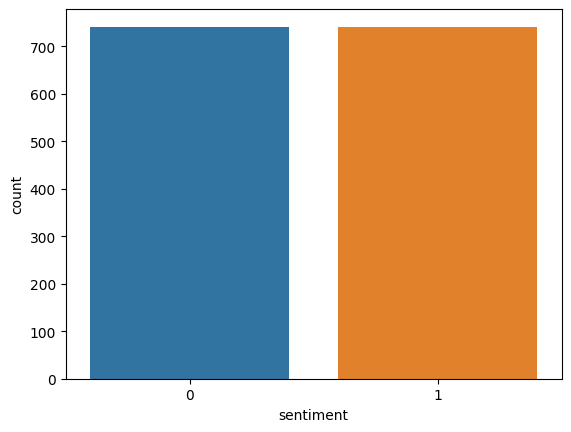

In [15]:
data_df = equal_ratio(data_df)
sns.countplot(x='sentiment', data=data_df)

In [16]:
# spaCy는 파이썬의 자연어처리를 위한 오픈 소스 기반 라이브러리
import spacy
nlp = spacy.load("en_core_web_sm")

In [17]:
# 데이터 정규화 과정 겪은 후에 contents가 길이 0인 것은 제거
def preprocessing(review):
    #re
    review = re.sub("[^a-zA-Z]", " ", review)
    word_li = review.lower().split()
    sentence = ' '.join(word_li)

    # lemmatization (spacy)
    token_li = nlp(sentence)
    word_li = [token.lemma_ for token in token_li if not token.is_stop]

    # 문자열로 변환 (띄어쓰기 한 칸 기준으로)
    sentence = ' '.join(word_li)

    return sentence

In [18]:
from tqdm import tqdm
tqdm.pandas()
data_df["prepro"] = data_df["contents"].progress_apply(preprocessing)

100%|██████████| 1482/1482 [00:23<00:00, 62.45it/s]


# 샘플 데이터

In [19]:
sample_1 = "string is long"
sample_prepro_1 = preprocessing(sample_1)

print(sample_prepro_1)

sample_2 = "is is is "
sample_prepro_2 = preprocessing(sample_2)

print(sample_prepro_2)
print(len(sample_prepro_2))

string long

0


In [20]:
print("공백 제거 전 데이터 개수: ", len(data_df))

not_empty_value = data_df["prepro"] != ""
data_df = data_df[not_empty_value]
print("공백 제거 후 데이터 개수: ", len(data_df))

공백 제거 전 데이터 개수:  1482
공백 제거 후 데이터 개수:  1478


In [21]:
x_feature = data_df["prepro"].copy()
y_label = data_df["sentiment"].copy()

# 훈련 세트 및 테스트 세트 나누기

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x_feature, y_label, test_size=0.2, random_state=42)

In [23]:
print(x_train[0:5])
print("*"*20)
print(y_train[0:5])

407    great variety trainer program expose user new ...
480    minus score star low go month subscription sta...
600    love app plan easy follow meal plan tasty reci...
912    app duck nuts s get food workout meditation s ...
530    app complete joke workout great free trial gre...
Name: prepro, dtype: object
********************
407    1
480    0
600    1
912    1
530    0
Name: sentiment, dtype: int64


In [24]:
print(x_test[0:5])
print("*"*20)
print(y_test[0:5])

663    app business expensive not program sound inter...
274                                               usless
395    app fantastic range meditation recipe exercise...
218    freak amaze workout great planner good food ch...
923    good fitness app planet don t pass think s cel...
Name: prepro, dtype: object
********************
663    0
274    0
395    1
218    1
923    1
Name: sentiment, dtype: int64


# Feature extraction and modeling

##BoW

In [25]:
# BoW embedding
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(analyzer='word', max_features=3000)

# train
x_bow_train = bow_vectorizer.fit_transform(x_train)
y_train = np.array(y_train)

# test
x_bow_test = bow_vectorizer.transform(x_test)
y_test = np.array(y_test)

In [26]:
# Logistic Regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# class_weight='balanced' 통해서 균형있게 학습
lg_bow_model = LogisticRegression(class_weight='balanced')

hyper_parmas = {"max_iter": [1000, 2000, 3000]}

grid_lr_bow_model = GridSearchCV(lg_bow_model, param_grid=hyper_parmas, cv=5, refit=True, return_train_score=True)
grid_lr_bow_model.fit(x_bow_train, y_train)

print(f"모델의 최고 정확도 : {grid_lr_bow_model.best_score_}")

estimator = grid_lr_bow_model.best_estimator_
pred_y_bow = estimator.predict(x_bow_test)

모델의 최고 정확도 : 0.9170564256597297


In [28]:
# SVM
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# class_weight='balanced' 통해서 균형있게 학습
svm_bow_model = SVC(class_weight='balanced')

hyper_params = {"max_iter": [10,100,1000, 2000, 3000]}

grid_svm_bow_model = GridSearchCV(svm_bow_model, param_grid=hyper_params, cv=5, refit=True, return_train_score=True)
grid_svm_bow_model.fit(x_bow_train, y_train)

print(f"모델의 최고 정확도 : {grid_svm_bow_model.best_score_}")

estimator_svm = grid_svm_bow_model.best_estimator_
pred_y_bow_svm = estimator_svm.predict(x_bow_test)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-proce

모델의 최고 정확도 : 0.9119895587499105


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Text(0.5, 427.9555555555555, 'Predicted label')

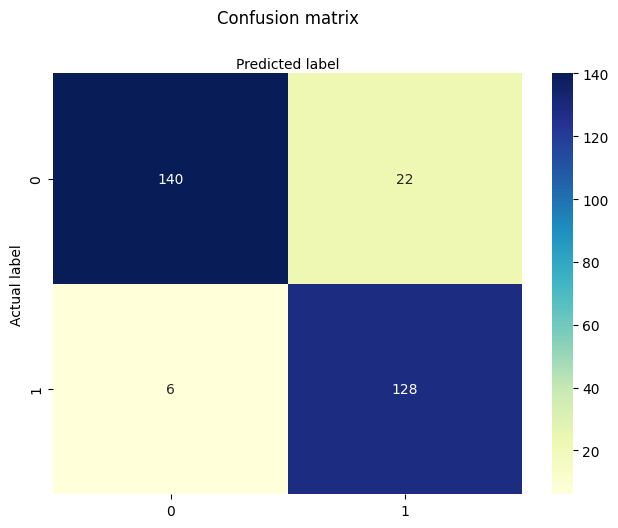

In [29]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, pred_y_bow)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 427.9555555555555, 'Predicted label')

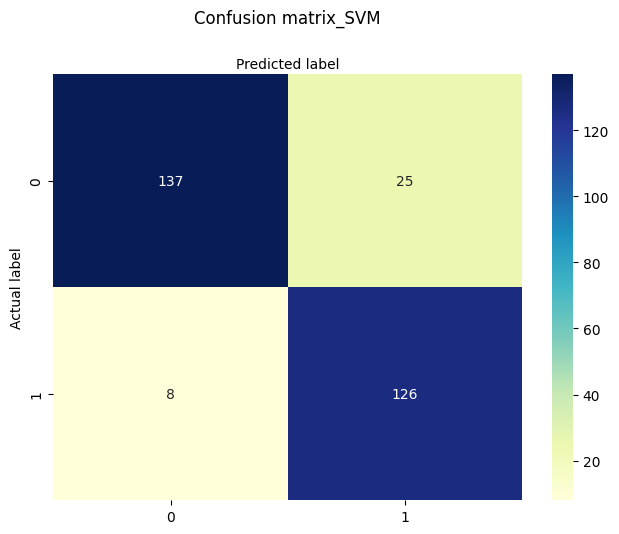

In [33]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, pred_y_bow_svm)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix_SVM', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_y_bow, target_names=['neg', 'pos']))

              precision    recall  f1-score   support

         neg       0.96      0.86      0.91       162
         pos       0.85      0.96      0.90       134

    accuracy                           0.91       296
   macro avg       0.91      0.91      0.91       296
weighted avg       0.91      0.91      0.91       296



In [31]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred_y_bow))

0.9054054054054054


In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_y_bow_svm, target_names=['neg', 'pos']))

              precision    recall  f1-score   support

         neg       0.94      0.85      0.89       162
         pos       0.83      0.94      0.88       134

    accuracy                           0.89       296
   macro avg       0.89      0.89      0.89       296
weighted avg       0.89      0.89      0.89       296



In [35]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred_y_bow_svm))

0.8885135135135135


## TF-IDF

In [36]:
# tfidf embedding
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df = 0.0, analyzer='word', ngram_range=(1,3), max_features=3000)

# train
x_tfidf_train = tfidf_vectorizer.fit_transform(x_train)
y_train = np.array(y_train)

# test
x_tfidf_test = tfidf_vectorizer.transform(x_test)
y_test = np.array(y_test)

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# class_weight='balanced' 통해서 균형있게 학습
lg_tfidf_model = LogisticRegression(class_weight='balanced')

hyper_parmas = {"max_iter": [1000, 2000, 3000]}

grid_lr_tfidf_model = GridSearchCV(lg_tfidf_model, param_grid=hyper_parmas, cv=5, refit=True, return_train_score=True)
grid_lr_tfidf_model.fit(x_tfidf_train, y_train)

print(f"모델의 최고 정확도 : {grid_lr_tfidf_model.best_score_}")

estimator = grid_lr_tfidf_model.best_estimator_
pred_y_tfidf = estimator.predict(x_tfidf_test)

모델의 최고 정확도 : 0.9297647142959308


In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# class_weight='balanced' 통해서 균형있게 학습
svm_tfidf_model = SVC(class_weight='balanced')

hyper_params = {"max_iter": [1000, 2000, 3000]}

grid_svm_tfidf_model = GridSearchCV(svm_tfidf_model, param_grid=hyper_params, cv=5, refit=True, return_train_score=True)
grid_svm_tfidf_model.fit(x_tfidf_train, y_train)

print(f"모델의 최고 정확도 : {grid_svm_tfidf_model.best_score_}")

estimator_svm_tfidf = grid_svm_tfidf_model.best_estimator_
pred_y_tfidf_svm = estimator_svm_tfidf.predict(x_tfidf_test)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider

모델의 최고 정확도 : 0.9331438174926696


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Text(0.5, 427.9555555555555, 'Predicted label')

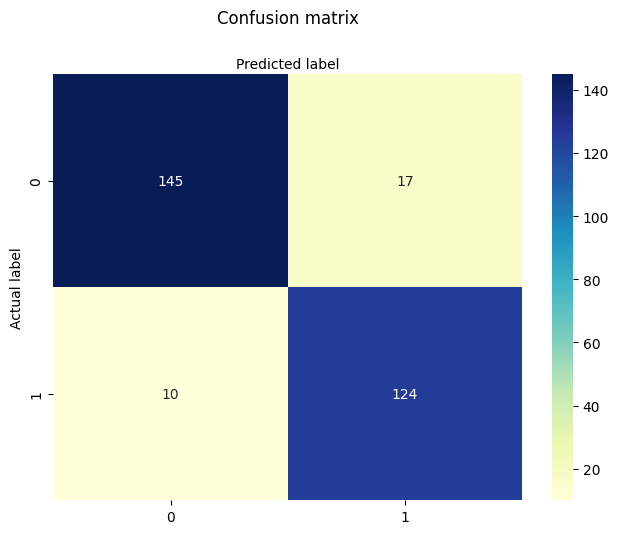

In [39]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, pred_y_tfidf)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 427.9555555555555, 'Predicted label')

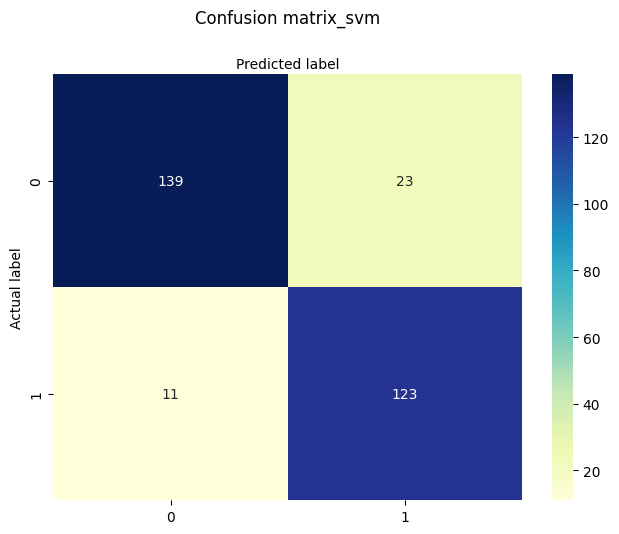

In [40]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, pred_y_tfidf_svm)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix_svm', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_y_tfidf, target_names=['neg', 'pos']))

              precision    recall  f1-score   support

         neg       0.91      0.92      0.92      1754
         pos       0.93      0.92      0.92      1838

    accuracy                           0.92      3592
   macro avg       0.92      0.92      0.92      3592
weighted avg       0.92      0.92      0.92      3592



In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred_y_tfidf))

0.9198218262806236


In [41]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_y_tfidf_svm, target_names=['neg', 'pos']))

              precision    recall  f1-score   support

         neg       0.93      0.86      0.89       162
         pos       0.84      0.92      0.88       134

    accuracy                           0.89       296
   macro avg       0.88      0.89      0.88       296
weighted avg       0.89      0.89      0.89       296



In [42]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred_y_tfidf_svm))

0.8851351351351351


##Word2Vec

In [43]:
# Word2Vec은 단어로 이루어진 리스트를 입력값으로 넣어야 한다.
x_train_li = [sentence.split() for sentence in list(x_train)]
x_test_li = [sentence.split() for sentence in list(x_test)]

In [44]:
!pip install gensim

In [45]:
from gensim.models import word2vec
model = word2vec.Word2Vec(x_train_li, vector_size=500, min_count=10, window=10)
model.save("./w2v_model")

In [46]:
def w2v_features(words, model, num_features):
  # w2v은 단어 별 벡터의 표현이 나오기 때문에, 문장을 표현해 줄때는, 단어 별 벡터의 합을 개수로 나눠서 표현한다.
  # 미리 정해준 feature 차원으로 np.zeros를 만들어 준다.
  feature_vector = np.zeros((num_features), dtype=np.float32)

  count = 0
  # 어휘사전 준비
  index2word_set = set(model.wv.index_to_key)

  for word in words:
    if word in index2word_set:
      count += 1
      # 사전에 해당하는 단어에 대한 단어 벡터를 더함
      feature_vector = np.add(feature_vector, model.wv[word])

  if count == 0:
    feature_vector = np.zeros((num_features), dtype=np.float32)
  else:
    feature_vector = np.divide(feature_vector, count)

  return feature_vector

In [47]:
def get_features(reviews, model, num_features):
  dataset = [w2v_features(sentence, model, num_features) for sentence in reviews]
  review_features_vecs = np.stack(dataset)

  return review_features_vecs

In [48]:
# train
x_w2v_train = get_features(x_train_li, model, num_features=500)
y_train = np.array(y_train)

# test
x_w2v_test = get_features(x_test_li, model, num_features=500)
y_test = np.array(y_test)

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# class_weight='balanced' 통해서 균형있게 학습
lg_w2v_model = LogisticRegression(class_weight='balanced')

hyper_parmas = {"max_iter": [1000, 2000, 3000]}

grid_lr_w2v_model = GridSearchCV(lg_w2v_model, param_grid=hyper_parmas, cv=5, refit=True, return_train_score=True)
grid_lr_w2v_model.fit(x_w2v_train, y_train)

print(f"모델의 최고 정확도 : {grid_lr_w2v_model.best_score_}")

estimator = grid_lr_w2v_model.best_estimator_
pred_y_w2v = estimator.predict(x_w2v_test)

모델의 최고 정확도 : 0.765608238575413


In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# class_weight='balanced' 통해서 균형있게 학습
svm_w2v_model = SVC(class_weight='balanced')

hyper_params = {"max_iter": [10,100,1000, 2000, 3000]}

grid_svm_w2v_model = GridSearchCV(svm_w2v_model, param_grid=hyper_params, cv=5, refit=True, return_train_score=True)
grid_svm_w2v_model.fit(x_w2v_train, y_train)

print(f"모델의 최고 정확도 : {grid_svm_w2v_model.best_score_}")

estimator_svm_w2v = grid_svm_w2v_model.best_estimator_
pred_y_w2v_svm = estimator_svm_w2v.predict(x_w2v_test)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-proce

모델의 최고 정확도 : 0.5126904097833084


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Text(0.5, 427.9555555555555, 'Predicted label')

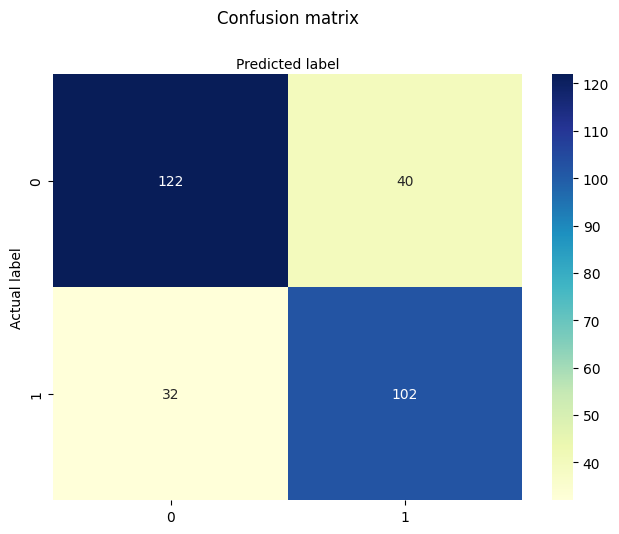

In [51]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, pred_y_w2v)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 427.9555555555555, 'Predicted label')

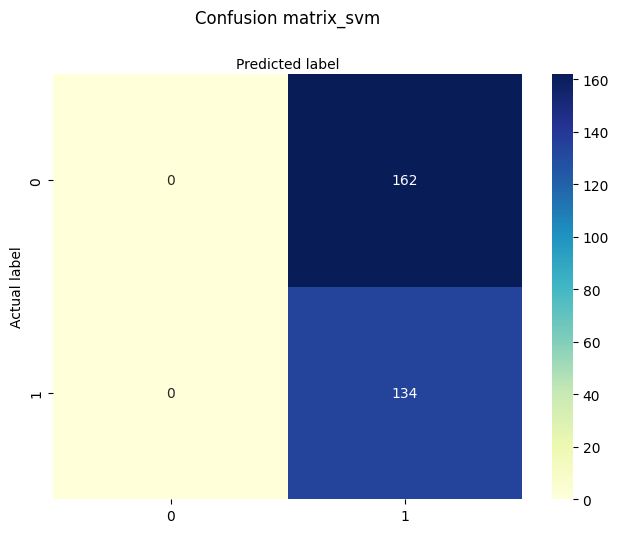

In [55]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, pred_y_w2v_svm)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix_svm', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [56]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_y_w2v, target_names=['neg', 'pos']))

              precision    recall  f1-score   support

         neg       0.79      0.75      0.77       162
         pos       0.72      0.76      0.74       134

    accuracy                           0.76       296
   macro avg       0.76      0.76      0.76       296
weighted avg       0.76      0.76      0.76       296



In [57]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred_y_w2v))

0.7567567567567568


In [58]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_y_w2v_svm, target_names=['neg', 'pos']))

              precision    recall  f1-score   support

         neg       0.00      0.00      0.00       162
         pos       0.45      1.00      0.62       134

    accuracy                           0.45       296
   macro avg       0.23      0.50      0.31       296
weighted avg       0.20      0.45      0.28       296



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred_y_w2v_svm))

0.4527027027027027


# 결과 저장

In [60]:
result_di = {
    "test_contents": x_test,
    "sentiment": y_test,
    "bow": pred_y_bow_svm,
    "tfidf": pred_y_tfidf_svm,
    "w2v": pred_y_w2v_svm
}
result_df = pd.DataFrame(result_di)
result_df.to_csv("./sentiment classification.csv")

In [61]:
print(result_df)

                                          test_contents  sentiment  bow  \
663   app business expensive not program sound inter...          0    0   
274                                              usless          0    1   
395   app fantastic range meditation recipe exercise...          1    1   
218   freak amaze workout great planner good food ch...          1    1   
923   good fitness app planet don t pass think s cel...          1    1   
...                                                 ...        ...  ...   
325   log weight set suck way price user friendly ha...          0    1   
1469  love far m day feel change recipe taste great ...          1    1   
1007  installation create account ok fine account cr...          0    0   
1230  centr reignite passion fitness health meal pla...          1    1   
317   dam hope free urghhh day trail isn t go fit an...          0    0   

      tfidf  w2v  
663       0    1  
274       1    1  
395       1    1  
218       1    1  
923 